In [1]:
from __future__ import division, print_function
from keras.models import load_model
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from sklearn.preprocessing import minmax_scale
from sklearn.linear_model import LinearRegression
from itertools import combinations
import keras.backend as K
import numpy as np
import pandas as pd
import os
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib.path as mplpath
from scipy.spatial.distance import cosine, cdist

from learning2learn.util import get_hidden_representations, similarity
from learning2learn.images import (generate_random_shape, generate_texture, 
                                   get_base_image, generate_image, generate_colors,
                                   add_texture, Texture)

np.random.seed(0)

Using TensorFlow backend.


In [2]:
IMG_SIZE = (200, 200)
model = load_model('../data/model.h5')
model.layers

In [3]:
def image_gen(shape, color, texture, target_size):
    generate_image(shape, color, texture, save_file='./temp.png')
    # Finally, load the image and return
    img = image.load_img('./temp.png', target_size=target_size)
    img = image.img_to_array(img)
    img /= 255.
    
    return img

In [4]:
def modHausdorffDistance(itemA, itemB):
    """
    Modified Hausdorff Distance
    
    Input
     itemA : [n x 2] coordinates of "inked" pixels
     itemB : [m x 2] coordinates of "inked" pixels
    
     M.-P. Dubuisson, A. K. Jain (1994). A modified hausdorff distance for object matching.
     International Conference on Pattern Recognition, pp. 566-568.
    """
    
    D = cdist(itemA, itemB)
    mindist_A = D.min(axis=1)
    mindist_B = D.min(axis=0)
    mean_A = np.mean(mindist_A)
    mean_B = np.mean(mindist_B)
    return max(mean_A,mean_B)

def euclidean(x1, x2):
    """
    Euclidean vector distance
    """
    return np.linalg.norm(x1 - x2)

In [5]:
def sample_color(color, var):
    cov = np.array([[var,0,0],[0,var,0],[0,0,var]])
    output = np.random.multivariate_normal(color, cov)
    return np.clip(output, a_min=0, a_max=1)

def get_feature_similarity_scores(values, nb_categories, distance_fn):
    scores = []
    i_vals = []
    j_vals = []
    for i, j in combinations(range(nb_categories), 2):
        i_vals.append(i)
        j_vals.append(j)
        score = distance_fn(values[i], values[j])
        scores.append(score)
    df = pd.DataFrame()
    df['i'] = i_vals
    df['j'] = j_vals
    df['score'] = scores
    
    return df

def bias_vs_feature_similarity(X_h1, df, X_h2=None):
    df_sorted = df.sort_values(by='score')
    biases = []
    similarities = []
    for k in range(len(df_sorted)):
        pair = df_sorted.iloc[k]
        i = int(pair['i'])
        j = int(pair['j'])
        similarities.append(pair['score'])
        if X_h2 is not None:
            biases.append(similarity(X_h1[i], X_h2[j]))
        else:
            biases.append(similarity(X_h1[i], X_h1[j]))
    
    return biases, similarities

def run_experiment(model, nb_categories, target_feature, others_constant=True, choose_one=False):
    assert target_feature in ['shape', 'color']
    # Choose one of ['ellipse', 'arc', 'arrow', 'circle', 'rectangle', 'wedge', 'pentagon'].
    # The texture will have no gradient for now.
    texture1 = generate_texture('ellipse', gradient=None, image_size=500)
    if target_feature == 'shape':
        # Generate 'nb_categories' random shapes
        values = [np.asarray(generate_random_shape(0, 500, 0, 500, 100)) for _ in range(nb_categories)]
        # Compute similarities between all pairs of shapes
        df = get_feature_similarity_scores(values, nb_categories, distance_fn=modHausdorffDistance)
        # Generate random color(s)
        #other1 = np.random.uniform(0, 1, size=3)
        other1 = np.array([0.31666667, 0.63333333, 0.63333333])
        imgs1 = np.asarray(
            [image_gen(value, other1, texture1, target_size=IMG_SIZE) for value in values]
        )
        if not others_constant:
            texture2 = generate_texture('rectangle', gradient=None, image_size=500)
            #other2 = np.random.uniform(0, 1, size=3)
            other2 = np.array([0.95, 0.31666667, 0.31666667])
            imgs2 = np.asarray(
                [image_gen(value, other2, texture2, target_size=IMG_SIZE) for value in values]
            )
    else:
        # Generate 'nb_categories' random colors
        #values = np.random.uniform(low=0, high=1, size=(N,3))
        values = generate_colors(nb_categories)
        values = np.asarray(
            [sample_color(color, 0.005) for color in values]
        )
        # Compute similaries between all pairs of colors
        df = get_feature_similarity_scores(values, nb_categories, distance_fn=euclidean)
        #df = get_feature_similarity_scores(values, nb_categories, distance_fn=cosine)
        # Generate random shape(s)
        other1 = generate_random_shape(0, 500, 0, 500, 100)
        imgs1 = np.asarray(
            [image_gen(other1, value, texture1, target_size=IMG_SIZE) for value in values]
        )
        if not others_constant:
            texture2 = generate_texture('rectangle', gradient=None, image_size=500)
            other2 = generate_random_shape(0, 500, 0, 500, 100)
            imgs2 = np.asarray(
                [image_gen(other2, value, texture2, target_size=IMG_SIZE) for value in values]
            )
    if choose_one:
        df = df[df.i == 0]
    
    # Compute layer biases
    imgs_h1 = get_hidden_representations(model, imgs1, layer_num=-4, batch_size=32)
    if others_constant:
        biases, similarities = bias_vs_feature_similarity(imgs_h1, df)
    else:
        imgs_h2 = get_hidden_representations(model, imgs2, layer_num=-4, batch_size=32)
        biases, similarities = bias_vs_feature_similarity(imgs_h1, df, imgs_h2)
    biases = np.asarray(biases)
    similarities = 1 - minmax_scale(similarities)
        
    if others_constant:
        return imgs1, df, biases, similarities
    else:
        return (imgs1, imgs2), df, biases, similarities

In [6]:
def plot_two(x1, x2):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
    axes[0].imshow(x1)
    axes[0].axis('off')
    axes[1].imshow(x2)
    axes[1].axis('off')
    plt.show()
    
def show_pair(imgs1, imgs2, df_sorted, k):
    pair = df_sorted.iloc[k]
    i = int(pair['i'])
    j = int(pair['j'])
    score = pair['score']
    print('Distance between #%i and #%i: %0.2f' % (i, j, score))
    plot_two(imgs1[i], imgs2[j])

# Start w/ others_constant=True

## First, try parametrically varying shape

In [7]:
imgs_s, df_s, biases_s, similarities_s = run_experiment(model, 20, target_feature='shape')

In [8]:
lr = LinearRegression()
lr.fit(similarities_s.reshape(-1,1), biases_s)
x_grid = np.linspace(0, 1).reshape(-1,1)
y_grid = lr.predict(x_grid)

/Users/reubenfeinman/anaconda/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


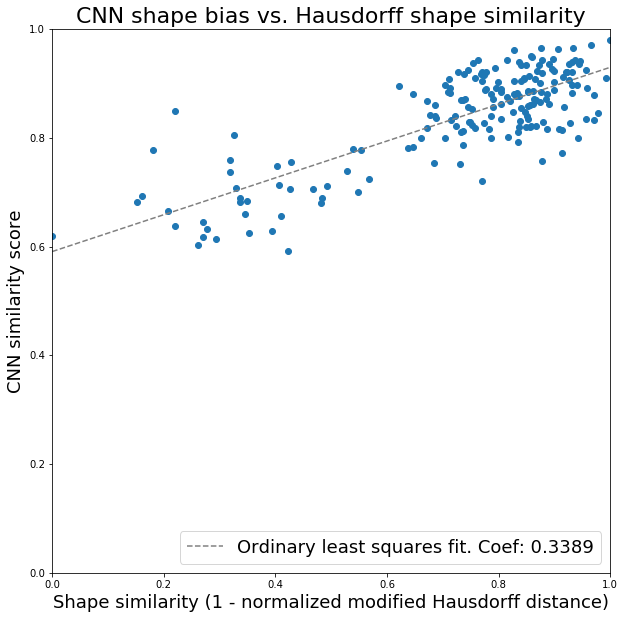

In [9]:
# Plot results
plt.figure(figsize=(10,10))
plt.scatter(similarities_s, biases_s)
plt.plot(x_grid, y_grid, '--', color='grey', label='Ordinary least squares fit. Coef: %0.4f' % lr.coef_[0])
plt.title('CNN shape bias vs. Hausdorff shape similarity', fontsize=22)
plt.xlabel('Shape similarity (1 - normalized modified Hausdorff distance)', fontsize=18)
plt.ylabel('CNN similarity score', fontsize=18)
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(loc='lower right', fontsize=18)
plt.show()

Distance between #0 and #1: 41.02


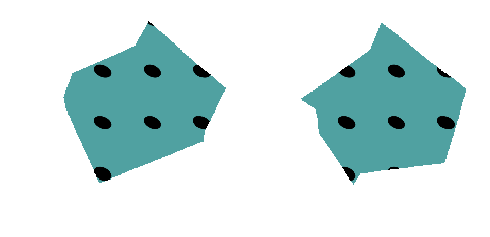

Distance between #7 and #17: 42.19


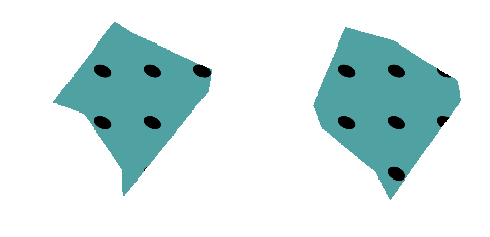

Distance between #0 and #4: 44.34


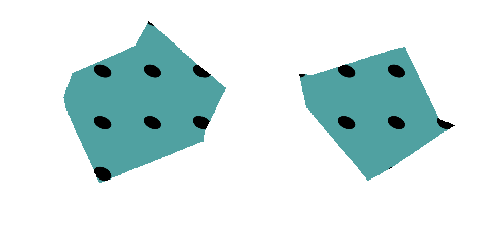

Distance between #6 and #13: 45.45


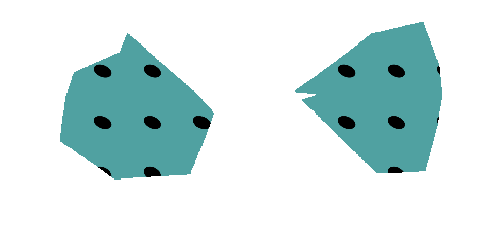

Distance between #0 and #6: 45.57


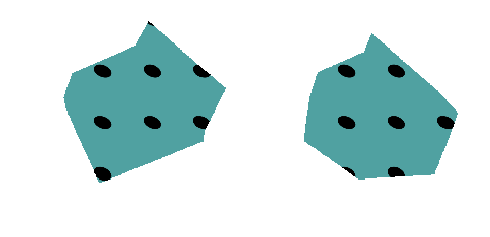




........



Distance between #10 and #12: 161.95


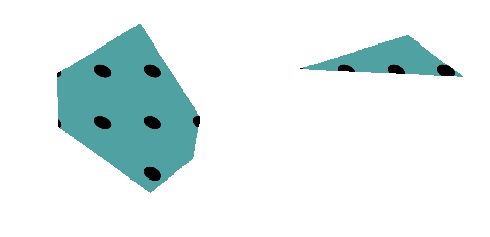

Distance between #12 and #17: 166.12


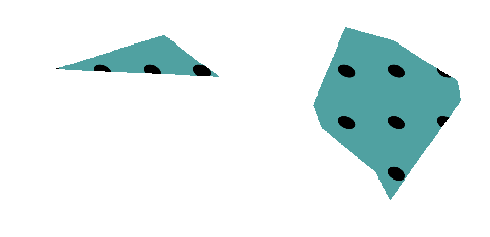

Distance between #9 and #12: 169.16


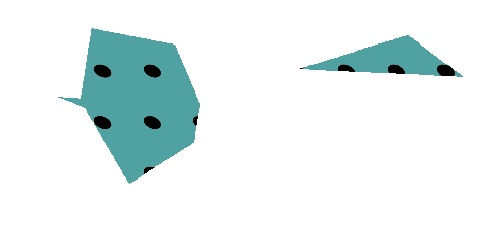

Distance between #1 and #12: 170.47


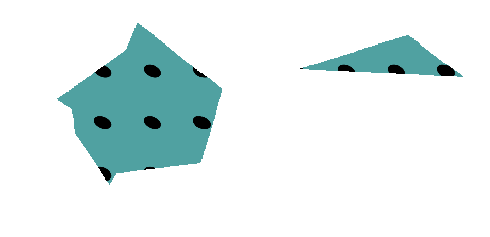

Distance between #12 and #15: 193.77


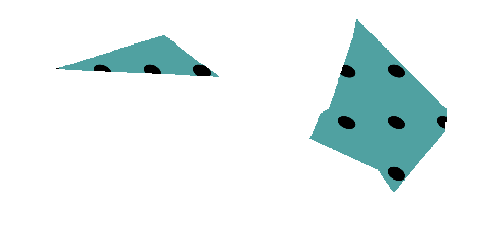

In [10]:
df_sorted = df_s.sort_values(by='score')
inds = list(range(len(df_sorted)))
for k in inds[:5]:
    show_pair(imgs_s, imgs_s, df_sorted, k)
print('\n\n\n........\n\n\n')
for k in inds[-5:]:
    show_pair(imgs_s, imgs_s, df_sorted, k)

## Now, try parametrically varying color

In [30]:
imgs_c, df_c, biases_c, similarities_c = run_experiment(model, 20, target_feature='color')

In [31]:
lr = LinearRegression()
lr.fit(similarities_c.reshape(-1,1), biases_c)
x_grid = np.linspace(0, 1).reshape(-1,1)
y_grid = lr.predict(x_grid)

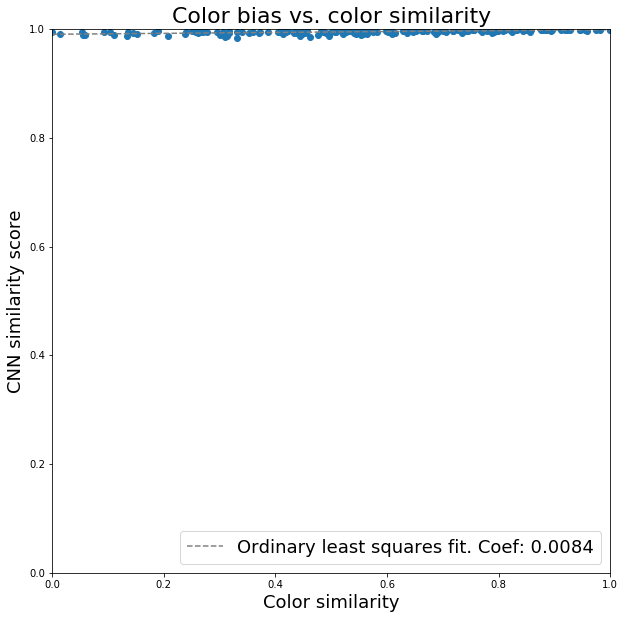

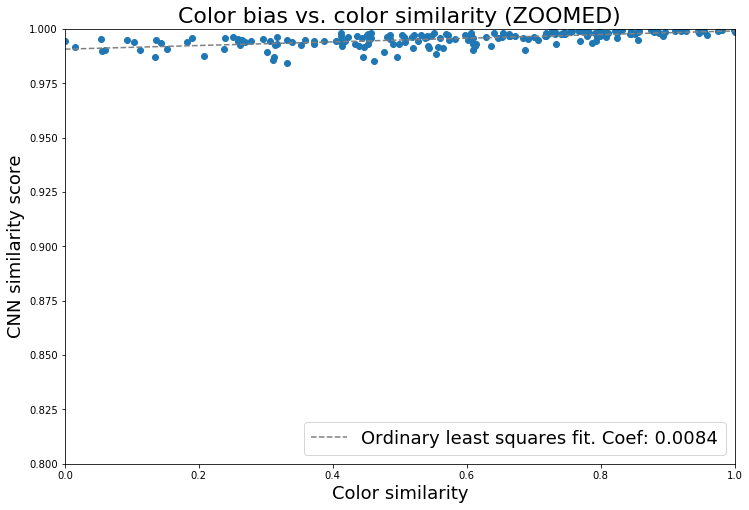

In [32]:
# Plot results
plt.figure(figsize=(10, 10))
plt.scatter(similarities_c, biases_c)
plt.plot(x_grid, y_grid, '--', color='grey', label='Ordinary least squares fit. Coef: %0.4f' % lr.coef_[0])
plt.title('Color bias vs. color similarity', fontsize=22)
plt.xlabel('Color similarity', fontsize=18)
plt.ylabel('CNN similarity score', fontsize=18)
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(loc='lower right', fontsize=18)
plt.show()

print('\n\n\n')
# Plot results
plt.figure(figsize=(12, 8))
plt.scatter(similarities_c, biases_c)
plt.plot(x_grid, y_grid, '--', color='grey', label='Ordinary least squares fit. Coef: %0.4f' % lr.coef_[0])
plt.title('Color bias vs. color similarity (ZOOMED)', fontsize=22)
plt.xlabel('Color similarity', fontsize=18)
plt.ylabel('CNN similarity score', fontsize=18)
plt.xlim(0,1)
plt.ylim(0.8,1)
plt.legend(loc='lower right', fontsize=18)
plt.show()

Distance between #9 and #15: 0.24


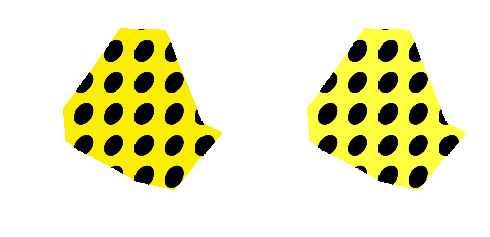

Distance between #3 and #11: 0.24


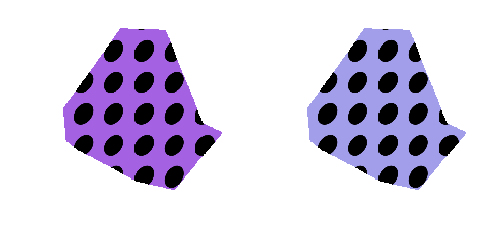

Distance between #0 and #10: 0.26


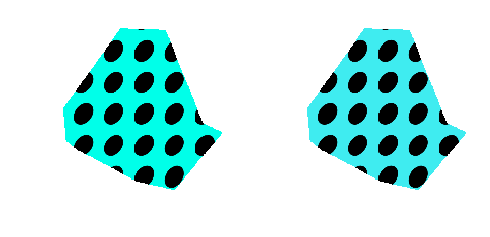

Distance between #6 and #13: 0.27


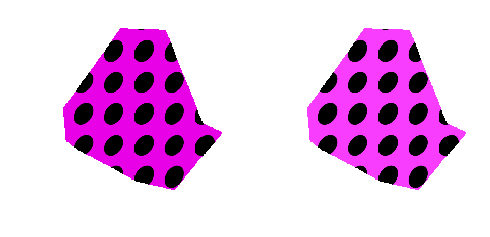

Distance between #5 and #12: 0.29


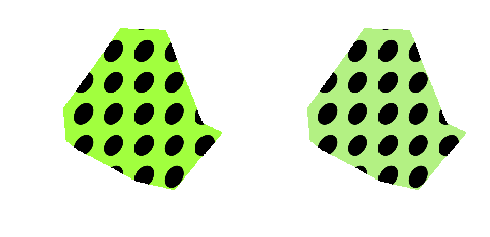

Distance between #11 and #17: 0.29


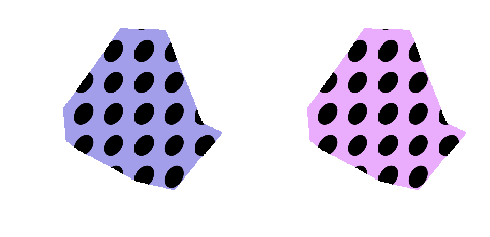

Distance between #16 and #19: 0.30


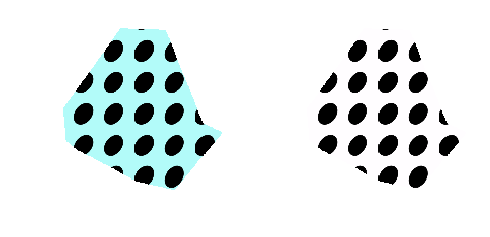

Distance between #15 and #18: 0.30


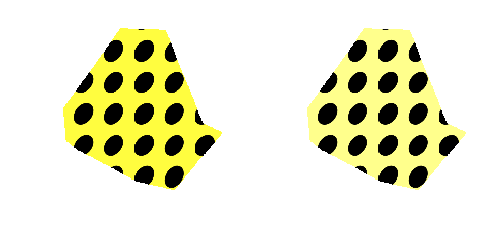

Distance between #12 and #18: 0.30


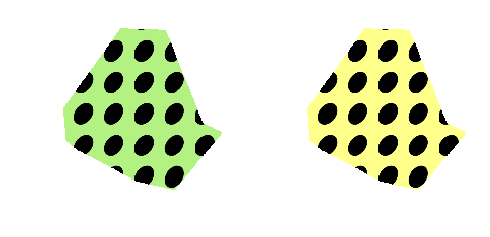

Distance between #14 and #17: 0.32


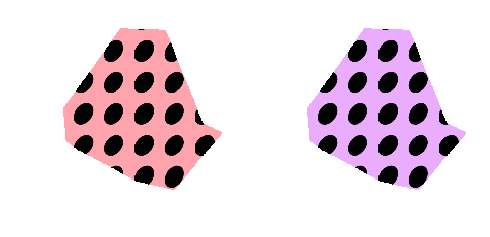

Distance between #17 and #19: 0.33


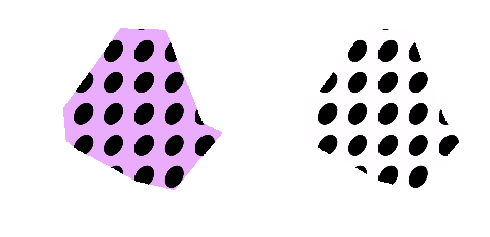

Distance between #8 and #15: 0.33


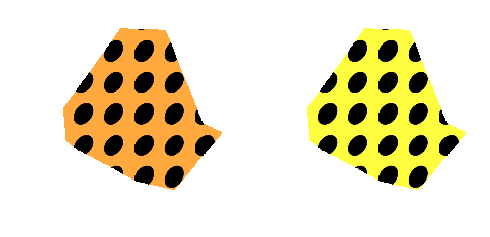

Distance between #2 and #12: 0.34


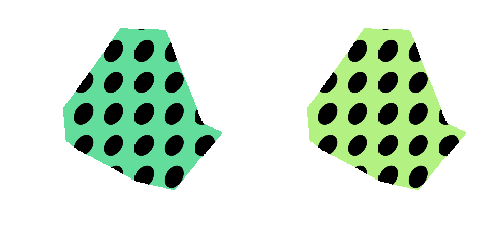

Distance between #8 and #9: 0.36


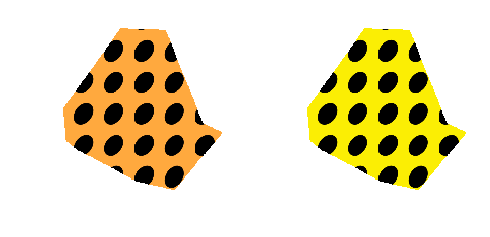

Distance between #3 and #4: 0.36


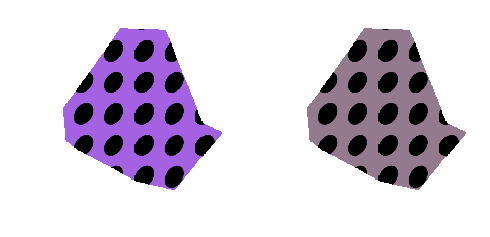




........



Distance between #1 and #9: 1.29


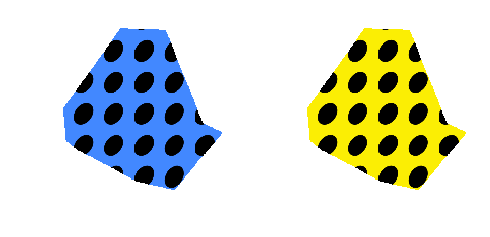

Distance between #6 and #9: 1.29


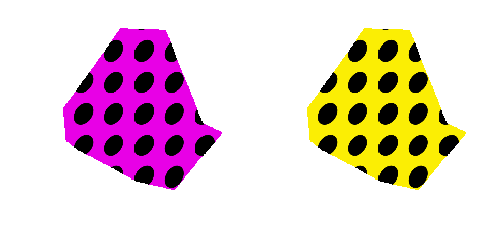

Distance between #0 and #7: 1.29


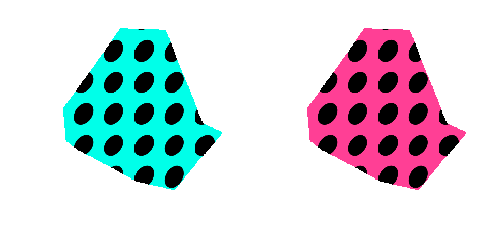

Distance between #0 and #9: 1.34


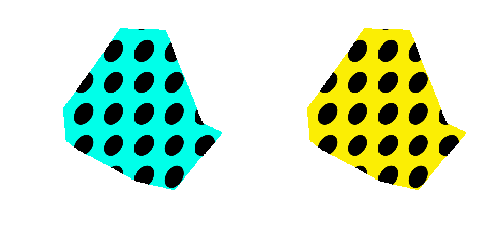

Distance between #0 and #6: 1.35


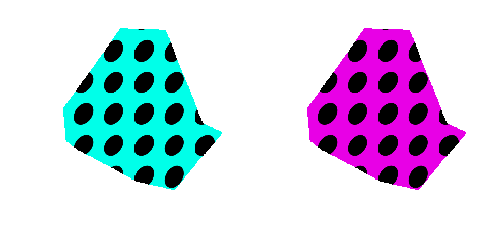

In [33]:
df_sorted = df_c.sort_values(by='score')
inds = list(range(len(df_sorted)))
for k in inds[:15]:
    show_pair(imgs_c, imgs_c, df_sorted, k)
print('\n\n\n........\n\n\n')
for k in inds[-5:]:
    show_pair(imgs_c, imgs_c, df_sorted, k)

# Move on to others_constant=False

## parametrically vary shape

In [16]:
imgs_s, df_s, biases_s, similarities_s = run_experiment(model, 20, target_feature='shape', others_constant=False)

In [17]:
lr = LinearRegression()
lr.fit(similarities_s.reshape(-1,1), biases_s)
x_grid = np.linspace(0, 1).reshape(-1,1)
y_grid = lr.predict(x_grid)

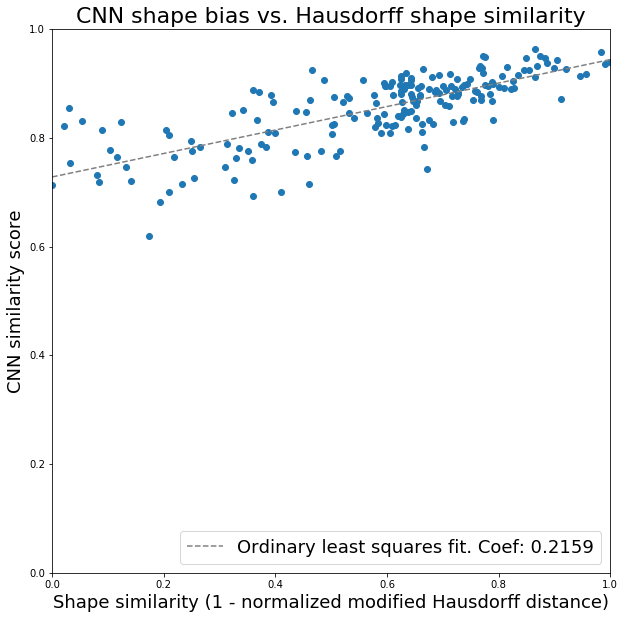

In [18]:
# Plot results
plt.figure(figsize=(10,10))
plt.scatter(similarities_s, biases_s)
plt.plot(x_grid, y_grid, '--', color='grey', label='Ordinary least squares fit. Coef: %0.4f' % lr.coef_[0])
plt.title('CNN shape bias vs. Hausdorff shape similarity', fontsize=22)
plt.xlabel('Shape similarity (1 - normalized modified Hausdorff distance)', fontsize=18)
plt.ylabel('CNN similarity score', fontsize=18)
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(loc='lower right', fontsize=18)
plt.show()

Distance between #6 and #15: 33.46


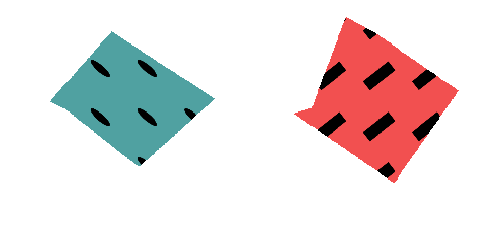

Distance between #2 and #18: 34.39


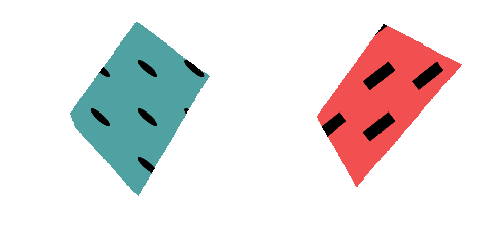

Distance between #4 and #12: 35.30


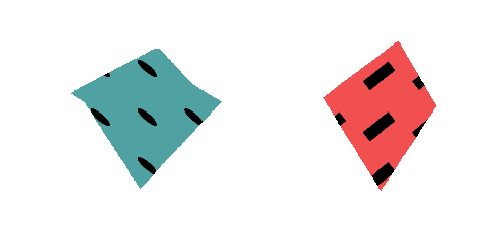

Distance between #12 and #13: 38.31


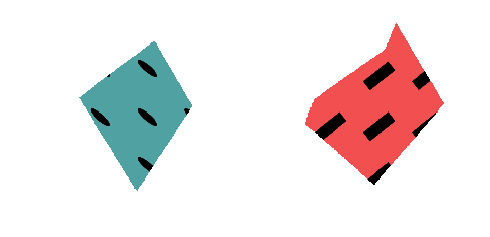

Distance between #1 and #16: 39.41


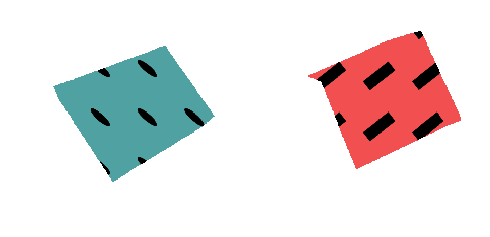




........



Distance between #2 and #8: 137.51


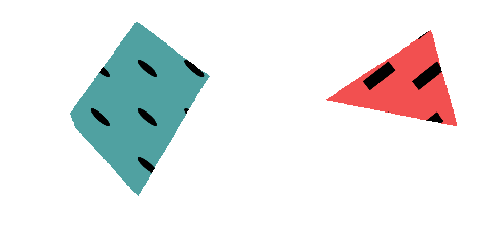

Distance between #3 and #14: 139.85


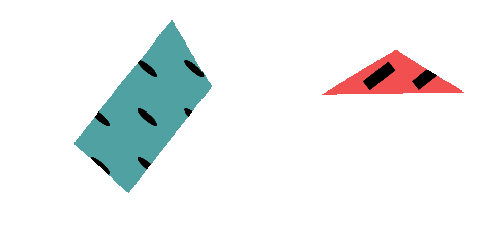

Distance between #3 and #8: 140.10


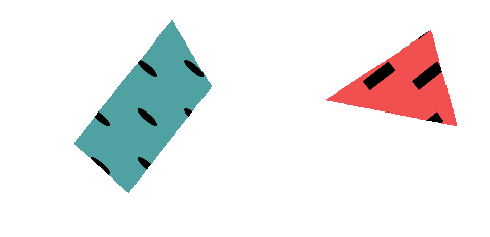

Distance between #8 and #18: 141.04


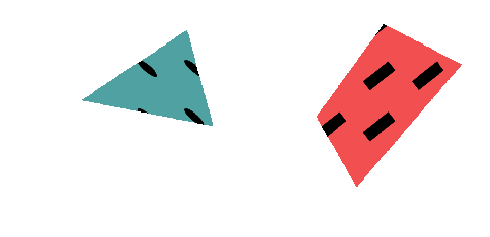

Distance between #3 and #11: 143.38


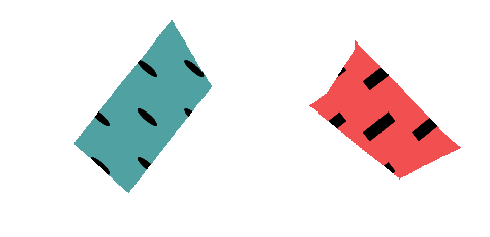

In [19]:
df_sorted = df_s.sort_values(by='score')
inds = list(range(len(df_sorted)))
for k in inds[:5]:
    show_pair(imgs_s[0], imgs_s[1], df_sorted, k)
print('\n\n\n........\n\n\n')
for k in inds[-5:]:
    show_pair(imgs_s[0], imgs_s[1], df_sorted, k)

## parametrically vary color

In [20]:
imgs_c, df_c, biases_c, similarities_c = run_experiment(model, 20, target_feature='color', others_constant=False)

In [21]:
lr = LinearRegression()
lr.fit(similarities_c.reshape(-1,1), biases_c)
x_grid = np.linspace(0, 1).reshape(-1,1)
y_grid = lr.predict(x_grid)

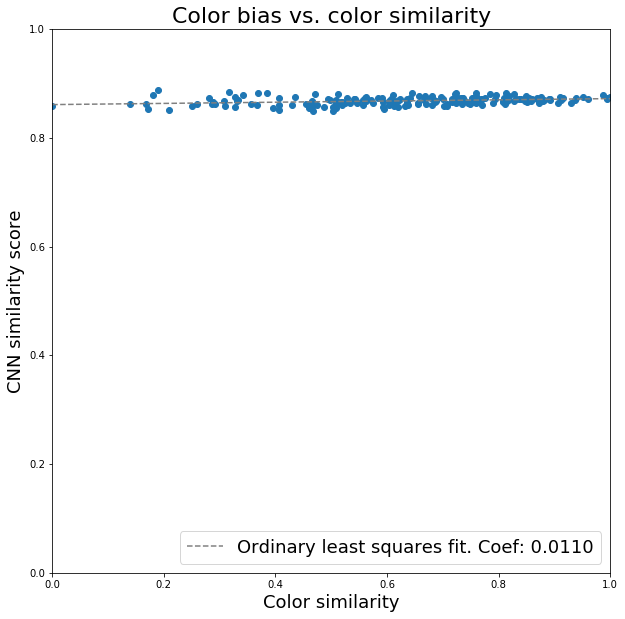

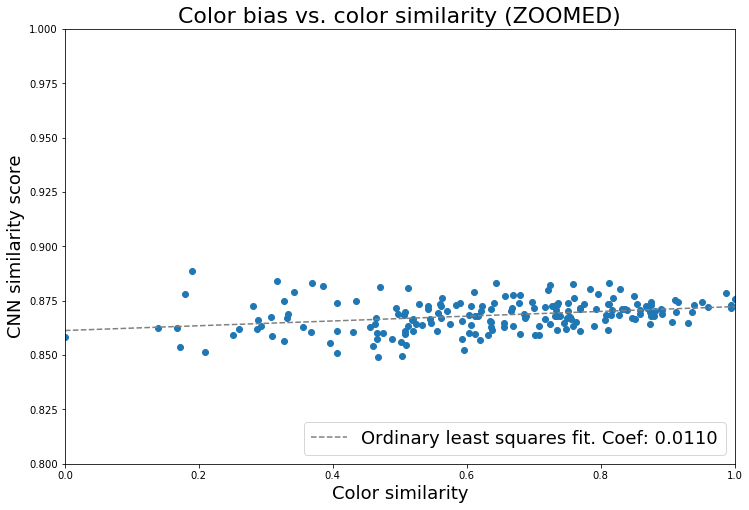

In [22]:
# Plot results
plt.figure(figsize=(10, 10))
plt.scatter(similarities_c, biases_c)
plt.plot(x_grid, y_grid, '--', color='grey', label='Ordinary least squares fit. Coef: %0.4f' % lr.coef_[0])
plt.title('Color bias vs. color similarity', fontsize=22)
plt.xlabel('Color similarity', fontsize=18)
plt.ylabel('CNN similarity score', fontsize=18)
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(loc='lower right', fontsize=18)
plt.show()

print('\n\n\n')
# Plot results
plt.figure(figsize=(12, 8))
plt.scatter(similarities_c, biases_c)
plt.plot(x_grid, y_grid, '--', color='grey', label='Ordinary least squares fit. Coef: %0.4f' % lr.coef_[0])
plt.title('Color bias vs. color similarity (ZOOMED)', fontsize=22)
plt.xlabel('Color similarity', fontsize=18)
plt.ylabel('CNN similarity score', fontsize=18)
plt.xlim(0,1)
plt.ylim(0.8,1)
plt.legend(loc='lower right', fontsize=18)
plt.show()

Distance between #4 and #12: 0.18


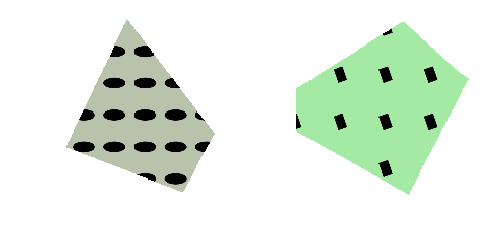

Distance between #14 and #15: 0.18


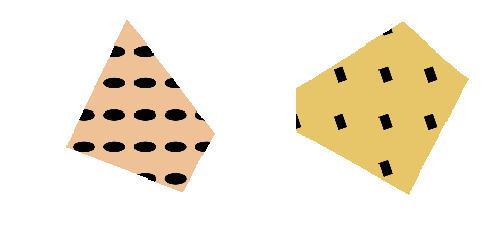

Distance between #8 and #15: 0.18


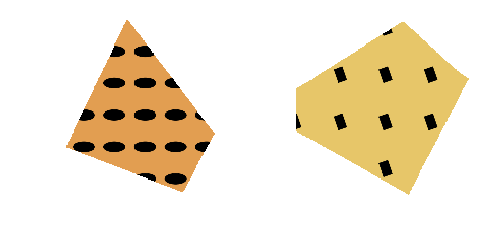

Distance between #13 and #17: 0.19


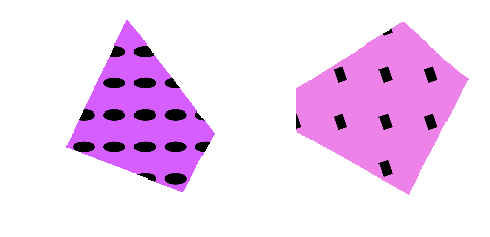

Distance between #4 and #14: 0.23


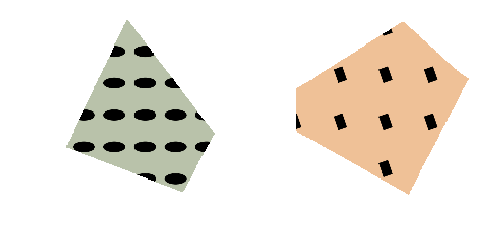




........



Distance between #6 and #9: 1.19


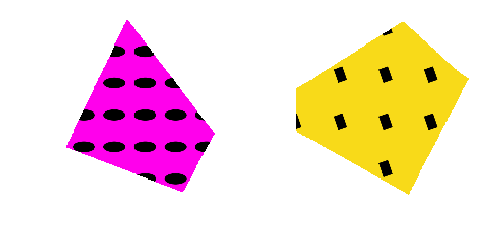

Distance between #5 and #6: 1.20


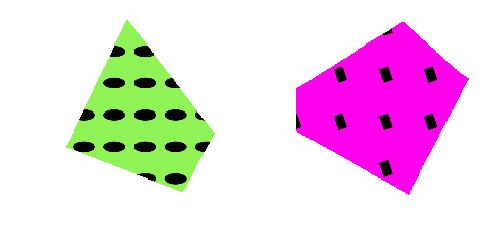

Distance between #0 and #7: 1.21


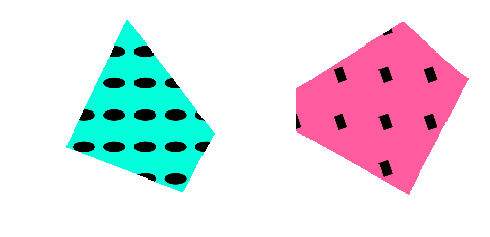

Distance between #0 and #9: 1.24


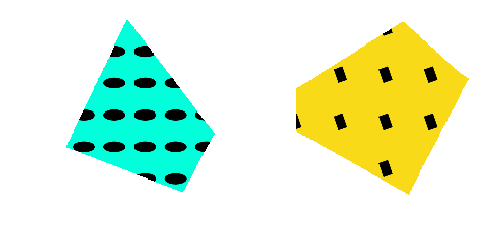

Distance between #0 and #6: 1.42


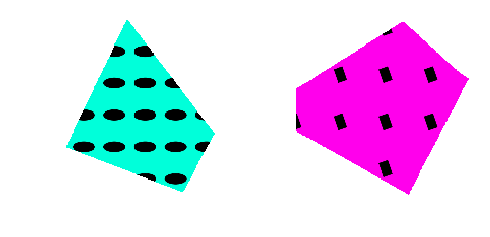

In [24]:
df_sorted = df_c.sort_values(by='score')
inds = list(range(len(df_sorted)))
for k in inds[:5]:
    show_pair(imgs_c[0], imgs_c[1], df_sorted, k)
print('\n\n\n........\n\n\n')
for k in inds[-5:]:
    show_pair(imgs_c[0], imgs_c[1], df_sorted, k)

# Try something different.... have the same base sample, parametrically vary the comparison sample

In [25]:
imgs_s1, df_s1, biases_s1, similarities_s1 = run_experiment(model, 20, target_feature='shape', choose_one=True)

In [36]:
lr = LinearRegression()
lr.fit(similarities_s1.reshape(-1,1), biases_s1)
x_grid = np.linspace(0, 1).reshape(-1,1)
y_grid = lr.predict(x_grid)

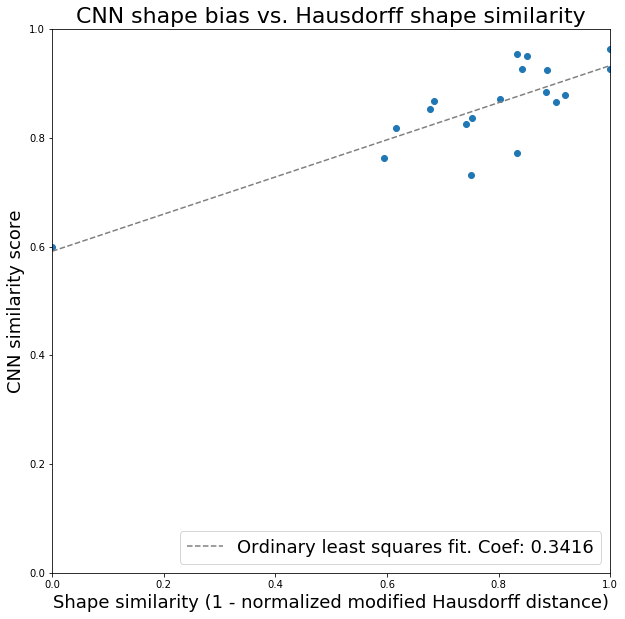

In [37]:
# Plot results
plt.figure(figsize=(10, 10))
plt.scatter(similarities_s1, biases_s1)
plt.plot(x_grid, y_grid, '--', color='grey', label='Ordinary least squares fit. Coef: %0.4f' % lr.coef_[0])
plt.title('CNN shape bias vs. Hausdorff shape similarity', fontsize=22)
plt.xlabel('Shape similarity (1 - normalized modified Hausdorff distance)', fontsize=18)
plt.ylabel('CNN similarity score', fontsize=18)
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(loc='lower right', fontsize=18)
plt.show()

Distance between #0 and #3: 43.59


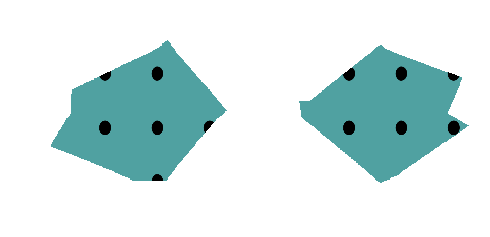

Distance between #0 and #8: 43.69


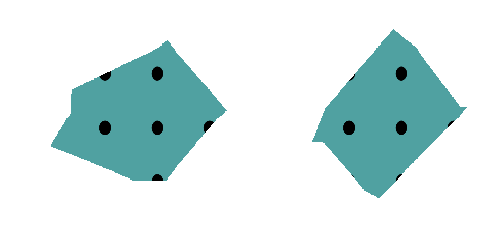

Distance between #0 and #9: 51.41


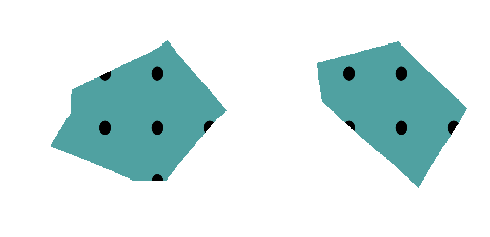

Distance between #0 and #5: 52.92


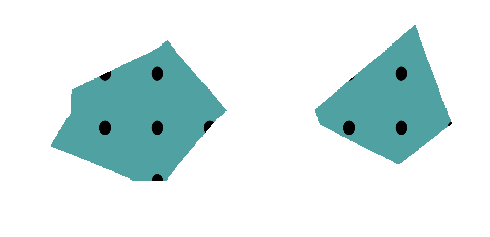

Distance between #0 and #12: 54.59


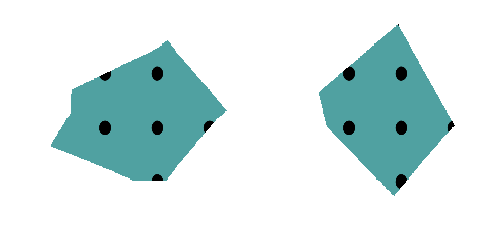

Distance between #0 and #15: 74.17


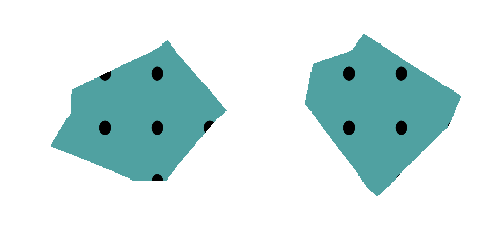

Distance between #0 and #19: 74.89


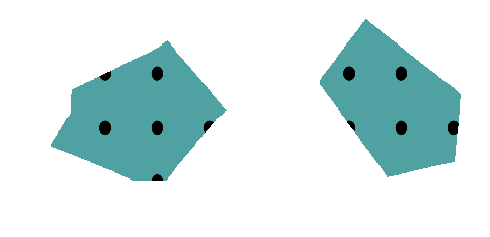

Distance between #0 and #14: 80.82


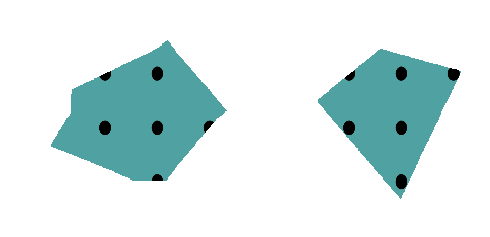

Distance between #0 and #6: 82.76


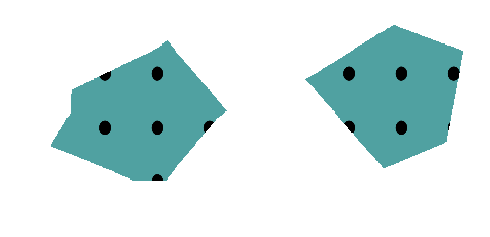

Distance between #0 and #13: 140.38


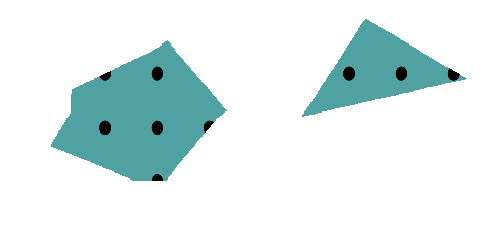

In [28]:
df_sorted = df_s1.sort_values(by='score')
inds = list(range(len(df_sorted)))
for k in inds[:5] + inds[-5:]:
    show_pair(imgs_s1, imgs_s1, df_sorted, k)